# Investigating PEGS for Bolivia 1994 Earthquake 

Data used: 
* Downloaded real data for IRIS from three stations
  - LPAZ (GT)
  - NNA (II)
  - YUNZ (XE)
* Synthetics are created using the following CMTSOLUTION file: 
    ```
  PDE 1994  6  9  0 33 16.40 -13.8300  -67.5600 637.0 6.9 6.8 NORTHERN BOLIVIA
event name:     060994A        
time shift:     0.0000
half duration:  0.0000
latitude:      -13.8200
longitude:     -67.2500
depth:         647.1000
Mrr:      -7.590000e+27
Mtt:       7.750000e+27
Mpp:      -1.600000e+26
Mrt:      -2.503000e+28
Mrp:       4.200000e+26
Mtp:      -2.480000e+27
    ```
* Simulations are conducted with the following parameters: 
    ``` 
NEX:                192 
model:              s40RTS
OCEANS             .true.
ELLIPTICITY        .true.
TOPOGRAPHY         .true.
GRAVITY            .true.
FULL_GRAVITY       .true.
ROTATION           .true.
ATTENUATION        .true.
ATTENUATION_NEW    .false.
    ```
    
Locations of the source and receiver are shown here: 

![source_receiver.jpg](source_receiver.jpg)
    
    
## Parameters for processing:     

In [1]:

remove_response = True

# Data stations details etc
station = 'LPAZ'
networks = {'LPAZ': 'GT',
            'NNA' : 'II',
            'YUNZ': 'XE'
            }

# Source parameters: 
gauss_hdur = 20
CMT_offset_time = 29


# Filtering: 
bp_fmin   = 0.002          # Hz 
bp_fmax   = 0.03          # Hz
zerophase = False
corners   = 2
prefilter = [bp_fmin/4, 
             bp_fmin/2, # For real data before instrument response is removed 
             2*bp_fmax, 
             4*bp_fmax]


# Plotting time frame - event was at 00:33:16 UTC:
fs            = 17        # Label font size
lfs           = 15        # Legend font size 
gauss_col     = 'teal'    # Anything related to Gauss STF
scar_col      = 'orange'  # Anything related to Scardec STF
pre_event     = 300        # start plot at this time before event (seconds)
seconds_after = 550       # end plot at this time after event (seconds)


## Imports: 

In [2]:
import numpy as np
import obspy
from obspy.core.stream import Stream
from obspy.core.inventory import read_inventory
import matplotlib.pyplot as plt
from copy import copy
from wetools import obspy_gen_mpl, gauss_STF_convolve, normalise, gen_gaussian,pad_by_time, bp_filter, STF_convolve, normalise_by_area, bp_filter_ty
from load_synth_stn import load_synthetic_station

## Process data: 
#### Real data

1. Load data and slice out correct time window
2. Remove the instrument response given in IRIS XML file 
    - Output is displacement and then the trace is differentiated twice with respect to time using centred difference.
    - A pre-filter is applied to the signal before instrument response with corners at $[\frac{f_1}{4},\: \frac{f_1}{2},\: 2 f_2,\: 4f_2 ]$ where $f_1$ and $f_2$ are the bandpass limits applied in filtering later.
    
3. Vertical channel is selected and bandpassed between $f_1 = 0.005$ and $f_2 = 0.04$ Hz



In [3]:
# Get station data
def load_real_data(station, pre_event, seconds_after, filter='bandpass', f=[], corners=4, zp=True):
    
    # Calculate times relative to source time: 
    lb =  33*60 + 16  - pre_event         # origin time from 'pre_event'-seconds before origin time
    ub =  lb + pre_event + seconds_after  # upper time limit


    
    network = networks[station]

    # Read and slice up
    st = Stream()
    temp_st = obspy.read(f"./Bolivia_1994/data/real/{station}.{network}.mseed")
    temp_st = temp_st.slice(starttime=temp_st[0].stats.starttime + lb, endtime=temp_st[0].stats.starttime + ub)

    # Remove response if desired:
    if remove_response:
        inv = read_inventory(f"./Bolivia_1994/data/real/IRISDMC-{station}.{network}.xml")
        temp_st.remove_response(inventory=inv, output='DISP', pre_filt=prefilter, plot=False)
        temp_st.differentiate()
        temp_st.differentiate()

    stz = temp_st.select(channel='BHZ')
    # Vertical acceleration (bandpassed)
    if filter=='bandpass':
        Z_acc = stz.filter(type='bandpass', freqmin=f[0], freqmax=f[1], corners=corners, zerophase=zp)[0]
    elif filter=='highpass': 
        Z_acc = stz.filter(type='highpass', freq=f, corners=corners, zerophase=zp)[0]
    elif filter=='lowpass':
        Z_acc = stz.filter(type='lowpass', freq=f, corners=corners, zerophase=zp)[0]
    
    # convert to numpy for plotting/further manipulation
    x,y = obspy_gen_mpl(Z_acc) 
        
    
    return x-pre_event, y, network

x,y,network = load_real_data(station, 
                             pre_event, 
                             seconds_after, 
                             filter='bandpass', 
                             f=[bp_fmin, bp_fmax],
                             zp=zerophase, # zero phase
                             corners=corners)

#### Synthetic data

1. Synthetics for acceleration are loaded as well as other idealised-seismometer terms (e.g. Coriolis term)
2. Add in CMT offset time to the time array because it currently starts at 0 s 
3. Create a Gaussian STF with half-duration of 20 seconds (value in the true CMTSOLUTION) and same sampling rate as the synthetic data. 
4. Load [SCARDEC average STF](http://scardec.projects.sismo.ipgp.fr/) and rescale the amplitude so that its total area integrates to 1. 
5. Convolve the synethic acceleration data with the source time functions. 
6. Bandpass the convolved signals between $f_1 = 0.005$ and $f_2 = 0.04$ Hz 

In [4]:
# SYNTHETIC DATA:
synacc, corio, GRAV, PGRAV, sumarr = load_synthetic_station(station=station)
sacc_t = synacc[:,0]+ CMT_offset_time
sacc_DT = np.mean( sacc_t[1:] - sacc_t[:-1])


# ----------------------------- Gauss STF: -----------------------------
gstf_t, gstf = gen_gaussian(dt=sacc_DT, hdur=gauss_hdur)
gstf =  normalise_by_area(gstf_t, gstf)
gauss_acc = STF_convolve(data_dt=sacc_DT, data=copy(synacc[:,1]), stf_t=gstf_t, stf=gstf, timeshift=sacc_t[0])
# Convolved (gaussian) ground-acceleration data: 
gauss_acc_t = gauss_acc[:,0]
gauss_acc   = gauss_acc[:,1]


# ----------------------------- Scardec STFs: -----------------------------
scar_avg = np.loadtxt(f"./Bolivia_1994/STFs/scardec_avg", skiprows=2)
scar_avg_t = scar_avg[:,0]
scar_avg = normalise_by_area(x=scar_avg_t, y=scar_avg[:,1])
scar_acc = STF_convolve(data_dt=sacc_DT, data=copy(synacc[:,1]), stf_t=scar_avg_t, stf=scar_avg, timeshift=sacc_t[0])
# Convolved (SCARDEC) ground-acceleration data: 
scar_acc_t = scar_acc[:,0]
scar_acc   = scar_acc[:,1]


# Bandpass filter the convolved synthetics:
gauss_acc_t, gauss_acc = bp_filter(gauss_acc_t, gauss_acc, bp_fmin, bp_fmax, zerophase=zerophase, corners=corners)
scar_acc_t,  scar_acc  = bp_filter(scar_acc_t,  scar_acc,  bp_fmin, bp_fmax, zerophase=zerophase, corners=corners)


## Plotting: 

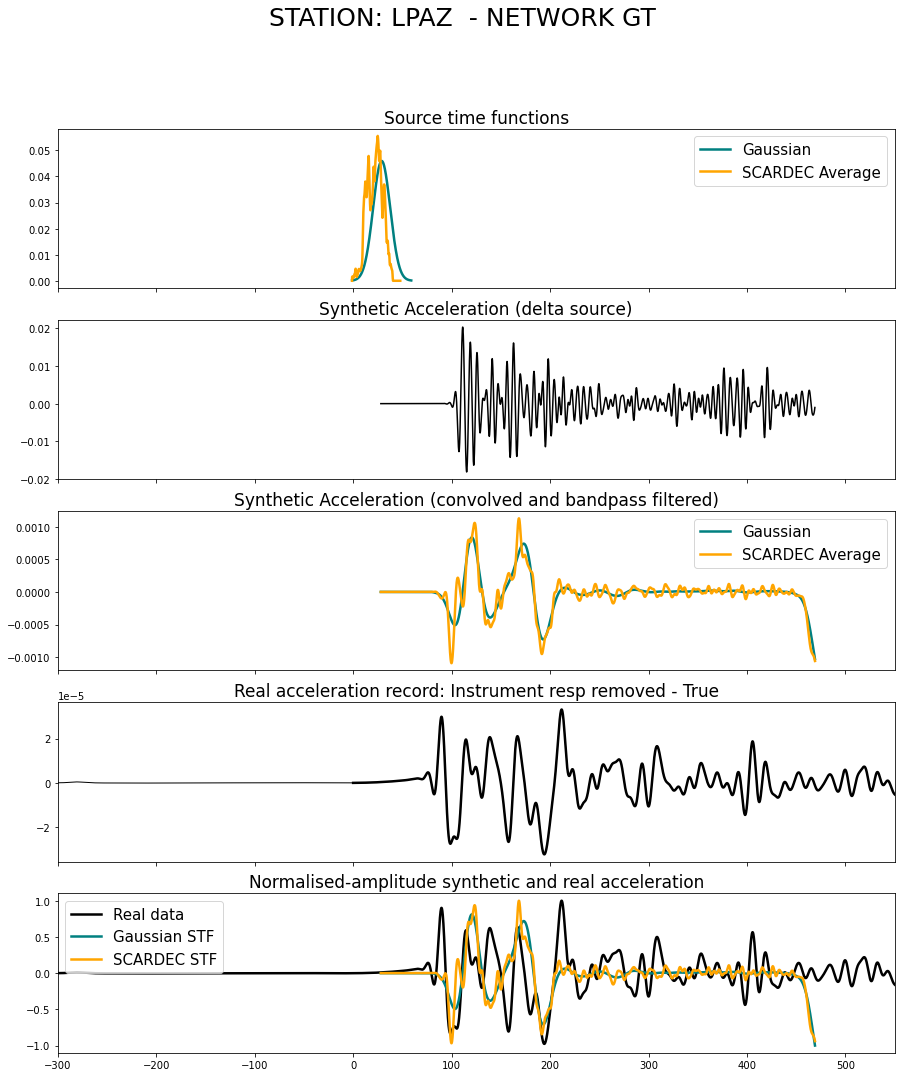

In [5]:

fig, ax = plt.subplots(5, figsize=(15, 17), sharex=True)
#fig, ax = plt.subplots(5, sharex=True, figsize=(10, 12))
#fig.set_tight_layout(True)
fig.suptitle(f'STATION: {station}  - NETWORK {network}', fontsize=25)


# Plot the STFs:
ax[0].plot(gstf_t+CMT_offset_time, gstf, gauss_col, linewidth=2.5)
ax[0].set_title("Source time functions", fontsize=fs)
ax[0].plot(scar_avg_t, scar_avg, scar_col, linewidth=2.5)
ax[0].legend(['Gaussian', 'SCARDEC Average'], fontsize=lfs)

# Share x limit: 
ax[0].set_xlim([-pre_event, seconds_after])

# Plot the raw synthetic Greens function 
ax[1].plot(sacc_t , synacc[:,1], 'k')
ax[1].set_title('Synthetic Acceleration (delta source)', fontsize=fs);


# GAUSS - Plot Convolved + BP results and for normalised traces
ax[2].plot(gauss_acc_t, gauss_acc, gauss_col, linewidth=2.5)
ax[2].plot(scar_acc_t,  scar_acc,  scar_col, linewidth=2.5)
ax[2].set_title('Synthetic Acceleration (convolved and bandpass filtered)', fontsize=fs);
ax[2].legend(['Gaussian', 'SCARDEC Average'], fontsize=lfs)


ax[3].plot(x , y, 'k', linewidth=1)
ax[3].plot(x[x>0], y[x>0], 'k', linewidth=2.5)
ax[3].set_title(f"Real acceleration record: Instrument resp removed - {remove_response}", fontsize=fs);


# Plot for normalised traces
ax[4].plot(x , normalise(y), 'k', linewidth=2.5)
ax[4].plot(gauss_acc_t , normalise(gauss_acc), gauss_col, linewidth=2.5)
ax[4].plot(scar_acc_t,  normalise(scar_acc),  'orange', linewidth=2.5)
ax[4].legend(['Real data', 'Gaussian STF', 'SCARDEC STF'], fontsize=lfs)
ax[4].set_title(f"Normalised-amplitude synthetic and real acceleration", fontsize=fs);



### A few notes on the plot above: 

* The source-time function makes a pretty limited effect on the resultant acceleration synthetic at bandwidths with a highest frequency around 0.2 to 0.3 Hz...but it starts to have an effect above these frequencies. Above this I dont think NEX is high enough anyway at 192. 
* **The synthetic waveforms have the correct form (as observed in the last plot) but are two order of magnitude different from the real data** 

# The effect of an idealised seismometer 

Hom Nath has updated SEMGPETSC so that not only does it output the acceleration in each direction but also 

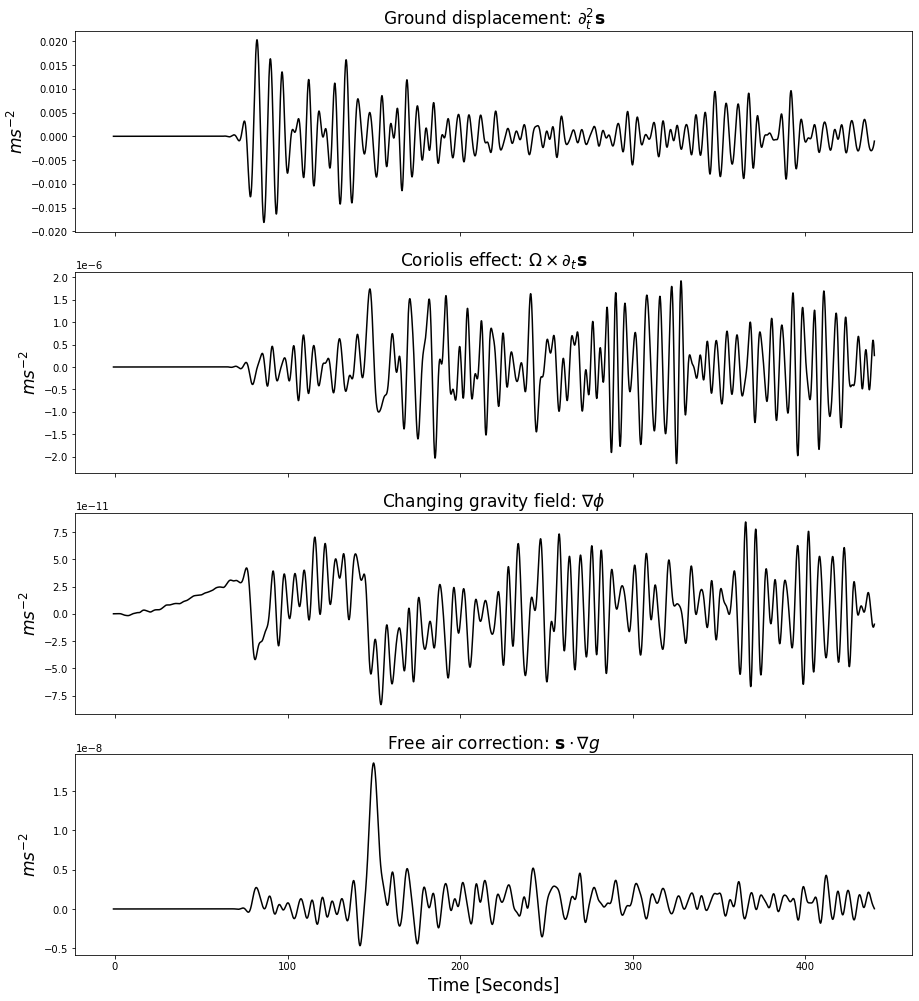

In [6]:
# Load the data for each 
#acc, corio, GRAV, PGRAV, sumarr = load_synthetic_station(station)
data = [synacc, corio, PGRAV, GRAV]


# Plot each data type 
fig_resp, ax_resp = plt.subplots(4, figsize=(15, 17), sharex=True)
terms = [r'Ground displacement: $\partial_t^2 \mathbf{s}$', r'Coriolis effect: $ \Omega \times \partial_t \mathbf{s} $', r'Changing gravity field: $\nabla \phi $', r'Free air correction: $\mathbf{s}\cdot \nabla g$' ]

for i in range(len(data)):
    d = data[i]
    ax_resp[i].plot(d[:,0], d[:,1], 'k')
    ax_resp[i].set_title(terms[i],fontsize=fs)
    ax_resp[i].set_ylabel(r'$m s^{-2}$', fontsize=fs)
    
    i+= 1

ax_resp[-1].set_xlabel('Time [Seconds]', fontsize=fs);






**Note then that the ground displacement is at least 4 orders of magnitude above the other effects for the vertical channel, for the raw Green's functions**. We now wish to look at how these terms vary when they have been convolved with an STF and filtered: 

(-1e-05, 1e-05)

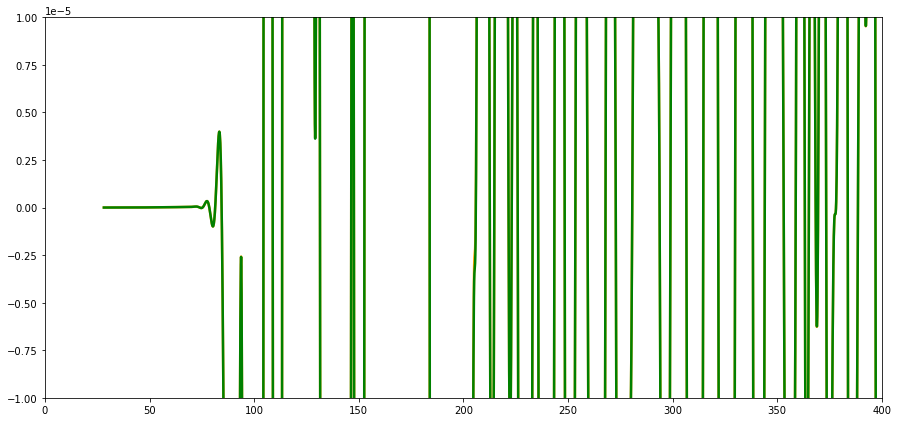

In [7]:

# Convolve the real seismometer (inc. coriolis etc) acceleration signal: 
bpseis_scar = STF_convolve(data_dt=sacc_DT, data=copy(sumarr), stf_t=scar_avg_t, stf=scar_avg, timeshift=sacc_t[0])
# Bandpass it: 
tacc_convbpseis, acc_convbpseis = bp_filter(t=bpseis_scar[:,0], 
                                            d=bpseis_scar[:,1], 
                                            fmin=bp_fmin, 
                                            fmax=bp_fmax,
                                            zerophase=zerophase,
                                            corners=corners)


# ============================== PLOTTING: ==============================
fig_bp_seis, ax_bp_seis = plt.subplots(figsize=(15,7))

# Plot original values for ground acceleration only from previous section: 
#ax_bp_seis.plot(gauss_acc_t, gauss_acc, 'b',      linewidth=2.5)
ax_bp_seis.plot(scar_acc_t,  scar_acc,  scar_col, linewidth=2.5)
ax_bp_seis.plot(tacc_convbpseis,  acc_convbpseis,  'green', linewidth=2.5)


val = 1e-5
ax_bp_seis.set_xlim([0,400])
ax_bp_seis.set_ylim([-val,val])




**Even when we zoom in to a acceleration scale of 1e-8 m/s2 there is no observable difference between the signal with and without the seismometer correction for an idealised seismometer** 

# Comparing with Vallee and Juhel 2019 

The first step will be to re-create the figure that they plotted, at least for the real data (and hopefully the synthetic if Martin decides to provide it) 

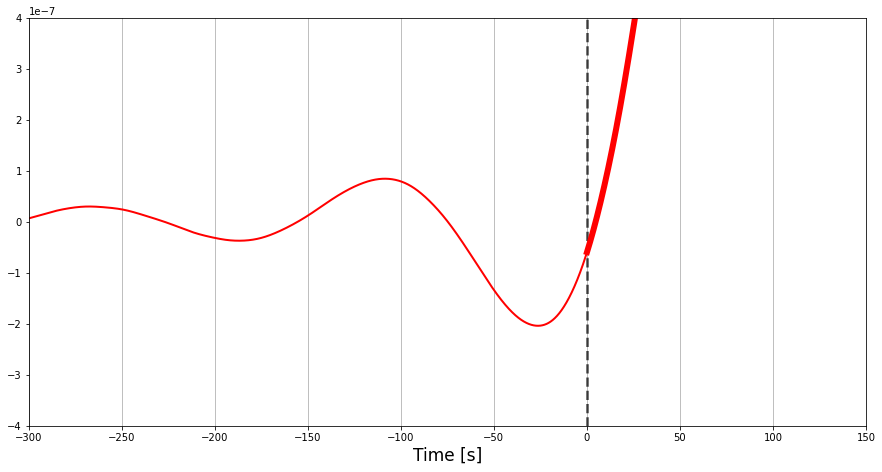

In [8]:
fig_jv, ax_jv = plt.subplots(figsize=(15, 7.5));

ax_jv.set_xlim([-300, 150]);
ax_jv.axvline(0, color='k', alpha=0.7, linewidth=2.5, linestyle='--')
ax_jv.set_xlabel('Time [s]', fontsize=fs)


# Load Real data: 
t_LPAZ, LPAZ, YN = load_real_data('LPAZ', 500, 150, filter='highpass', f=0.002, zp=False, corners=2)

# Apply an extra lowpass filter: 
from wetools import filter_timeseries 
t_LPAZ, LPAZ = filter_timeseries(t=t_LPAZ, d=LPAZ, type='lowpass', freq=0.03, zerophase=False, corners=6)

upper_cutoff_time = 100 


ax_jv.plot(t_LPAZ[t_LPAZ<0], LPAZ[t_LPAZ<0], 'r',linewidth=2)
mask = np.logical_and(t_LPAZ>=0, t_LPAZ<upper_cutoff_time)
ax_jv.plot(t_LPAZ[mask], LPAZ[mask], 'r', linewidth=6)

v = 4e-7

ax_jv.set_ylim([-v,v])
ax_jv.xaxis.grid(True)


# Plot our data: 
